<a href="https://colab.research.google.com/github/pietrogad/ICON24-25/blob/main/Classificazione_Pinguini_DT_ANN_NB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/Pinguin/dataset/penguins_size.csv"

In [ ]:
# ======================
# PREPARAZIONE DEI DATI
# ======================

#accedere al dataset e leggerlo
dataset = pd.read_csv(path)

In [ ]:
dataset.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [ ]:
#feature selection
dataset.drop(columns=["island","sex"], inplace=True)

In [ ]:
#eliminare i valori NaN (coperatura dei valori NaN)
dataset["body_mass_g"].fillna(np.mean(dataset["body_mass_g"]), inplace=True)
dataset["flipper_length_mm"].fillna(np.mean(dataset["flipper_length_mm"]), inplace=True)
dataset["culmen_depth_mm"].fillna(np.mean(dataset["culmen_depth_mm"]), inplace=True)
dataset["culmen_length_mm"].fillna(np.mean(dataset["culmen_length_mm"]), inplace=True)

/tmp/ipython-input-81-2401643219.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset["body_mass_g"].fillna(np.mean(dataset["body_mass_g"]), inplace=True)
/tmp/ipython-input-81-2401643219.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].me

In [ ]:
dataset.head()

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.10000,18.70000,181.000000,3750.000000
1,Adelie,39.50000,17.40000,186.000000,3800.000000
2,Adelie,40.30000,18.00000,195.000000,3250.000000
3,Adelie,43.92193,17.15117,200.915205,4201.754386
4,Adelie,36.70000,19.30000,193.000000,3450.000000


In [ ]:
# Preparazione dati
X = dataset.drop('species', axis=1).values
y = dataset['species'].values

In [ ]:
# Codifica delle etichette
le = LabelEncoder()
y_encoded = le.fit_transform(y)
species_names = le.classes_

print(f"Dataset cleaned: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Species distribution: {dict(pd.Series(y).value_counts())}")
print("="*70)

Dataset cleaned: 344 samples, 4 features
Species distribution: {'Adelie': np.int64(152), 'Gentoo': np.int64(124), 'Chinstrap': np.int64(68)}


In [ ]:
# ======================
# CONFIGURAZINE K-FOLD
# ======================

n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Strutture per memorizzare i risultati
results = {
    'Decision Tree': {'acc': [], 'f1': []},
    'Naive Bayes': {'acc': [], 'f1': []},
    'ANN': {'acc': [], 'f1': []}
}

In [ ]:
# ======================
# K-FOLD CROSS VALIDATION
# ======================

print(f"STARTING K-FOLD CROSS VALIDATION (k={n_splits})")
print("="*70)

for fold, (train_idx, test_idx) in enumerate(kfold.split(X)):
    print(f"\nFOLD {fold+1}/{n_splits}")
    print("-"*50)

    # Split dati
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

    # Standardizzazione
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ======================
    # 1. DECISION TREE
    # ======================

    dt_model = DecisionTreeClassifier(
        max_depth=3,
        min_samples_split=10,
        random_state=42
    )
    dt_model.fit(X_train_scaled, y_train)
    y_pred_dt = dt_model.predict(X_test_scaled)

    # Metriche Decision Tree
    dt_acc = accuracy_score(y_test, y_pred_dt)
    dt_f1 = f1_score(y_test, y_pred_dt, average='macro')
    results['Decision Tree']['acc'].append(dt_acc)
    results['Decision Tree']['f1'].append(dt_f1)

    print(f"Decision Tree - Accuracy: {dt_acc:.4f}, F1: {dt_f1:.4f}")

    # ======================
    # 2. NAIVE BAYES
    # ======================

    nb_model = GaussianNB()
    nb_model.fit(X_train_scaled, y_train)
    y_pred_nb = nb_model.predict(X_test_scaled)

    # Metriche Naive Bayes
    nb_acc = accuracy_score(y_test, y_pred_nb)
    nb_f1 = f1_score(y_test, y_pred_nb, average='macro')
    results['Naive Bayes']['acc'].append(nb_acc)
    results['Naive Bayes']['f1'].append(nb_f1)

    print(f"Naive Bayes  - Accuracy: {nb_acc:.4f}, F1: {nb_f1:.4f}")

    # ======================
    # 3. ANN
    # ======================

    # Preparazione dati per ANN
    y_train_cat = to_categorical(y_train)
    y_test_cat = to_categorical(y_test)

    # Creazione modello
    nn_model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(len(species_names), activation='softmax')
    ])

    # Compilazione
    nn_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Addestramento
    nn_model.fit(
        X_train_scaled, y_train_cat,
        epochs=100,
        batch_size=16,
        validation_split=0.2,
        verbose=0
    )

    # Valutazione
    _, nn_acc = nn_model.evaluate(X_test_scaled, y_test_cat, verbose=0)
    y_pred_nn = nn_model.predict(X_test_scaled)
    y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)
    nn_f1 = f1_score(y_test, y_pred_nn_classes, average='macro')
    results['ANN']['acc'].append(nn_acc)
    results['ANN']['f1'].append(nn_f1)

    print(f"ANN - Accuracy: {nn_acc:.4f}, F1: {nn_f1:.4f}")

STARTING K-FOLD CROSS VALIDATION (k=5)

FOLD 1/5
--------------------------------------------------
Decision Tree - Accuracy: 0.9275, F1: 0.9227
Naive Bayes  - Accuracy: 0.9565, F1: 0.9538


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
ANN - Accuracy: 0.9710, F1: 0.9714

FOLD 2/5
--------------------------------------------------
Decision Tree - Accuracy: 0.9565, F1: 0.9412
Naive Bayes  - Accuracy: 0.9565, F1: 0.9308


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
ANN - Accuracy: 0.9855, F1: 0.9890

FOLD 3/5
--------------------------------------------------
Decision Tree - Accuracy: 0.9565, F1: 0.9508
Naive Bayes  - Accuracy: 0.9565, F1: 0.9454


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
ANN - Accuracy: 0.9855, F1: 0.9818

FOLD 4/5
--------------------------------------------------
Decision Tree - Accuracy: 0.9565, F1: 0.9480
Naive Bayes  - Accuracy: 0.9855, F1: 0.9827


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
ANN - Accuracy: 1.0000, F1: 1.0000

FOLD 5/5
--------------------------------------------------
Decision Tree - Accuracy: 0.9559, F1: 0.9505
Naive Bayes  - Accuracy: 0.9853, F1: 0.9832


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
ANN - Accuracy: 0.9853, F1: 0.9832


In [ ]:
# ======================
# ANALISI DEI RISULTATI
# ======================

print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)

# Calcolo medie e deviazioni standard
final_results = {}
for model in results:
    mean_acc = np.mean(results[model]['acc'])
    std_acc = np.std(results[model]['acc'])
    mean_f1 = np.mean(results[model]['f1'])
    std_f1 = np.std(results[model]['f1'])

    final_results[model] = {
        'mean_acc': mean_acc,
        'std_acc': std_acc,
        'mean_f1': mean_f1,
        'std_f1': std_f1
    }

    print(f"\n{model.upper()}")
    print("-"*50)
    print(f"Mean Accuracy: {mean_acc:.4f}")
    print(f"Mean F1-Score: {mean_f1:.4f}")


FINAL RESULTS

DECISION TREE
--------------------------------------------------
Mean Accuracy: 0.9506
Mean F1-Score: 0.9427

NAIVE BAYES
--------------------------------------------------
Mean Accuracy: 0.9681
Mean F1-Score: 0.9592

ANN
--------------------------------------------------
Mean Accuracy: 0.9855
Mean F1-Score: 0.9851


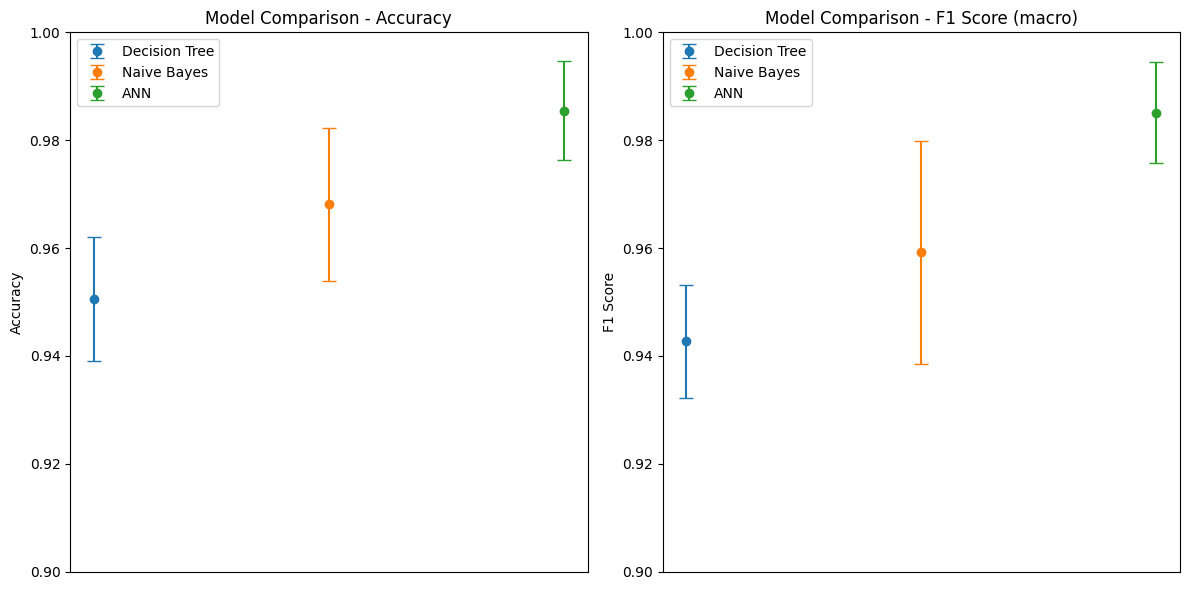


SUMMARY TABLE
Model                Accuracy        F1-Score       
--------------------------------------------------
Decision Tree        0.9506          0.9427         
Naive Bayes          0.9681          0.9592         
ANN                  0.9855          0.9851         


In [ ]:
# ======================
# VISUALIZZAZIONE
# ======================

# Grafico comparativo delle accuracy
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
for i, model in enumerate(results):
    plt.errorbar(
        i,
        final_results[model]['mean_acc'],
        yerr=final_results[model]['std_acc'],
        fmt='o',
        capsize=5,
        label=model
    )
plt.title('Model Comparison - Accuracy')
plt.xticks([])
plt.ylabel('Accuracy')
plt.ylim(0.90, 1.0)
plt.legend()

# F1-Score
plt.subplot(1, 2, 2)
for i, model in enumerate(results):
    plt.errorbar(
        i,
        final_results[model]['mean_f1'],
        yerr=final_results[model]['std_f1'],
        fmt='o',
        capsize=5,
        label=model
    )
plt.title('Model Comparison - F1 Score (macro)')
plt.xticks([])
plt.ylabel('F1 Score')
plt.ylim(0.90, 1.0)
plt.legend()

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300)
plt.show()

# Tabella riassuntiva
print("\n" + "="*70)
print("SUMMARY TABLE")
print("="*70)
print(f"{'Model':<20} {'Accuracy':<15} {'F1-Score':<15}")
print("-"*50)
for model in final_results:
    acc_str = f"{final_results[model]['mean_acc']:.4f}"
    f1_str = f"{final_results[model]['mean_f1']:.4f}"
    print(f"{model:<20} {acc_str:<15} {f1_str:<15}")